Rebuild street graph
====================
Loads a street graph and reallocates roads space, e.g., into a network of one-way streets

In [1]:
import snman
from snman import osmnx_customized as oxc
from snman.constants import *
import geopandas as gpd

PERIMETER = '_debug'
# Set SAVE_TO_DEBUG = True for saving the results into the _debug folder
# which is automatically used in the QGIS files
SAVE_TO_DEBUG = True

# Set these paths according to your own setup
data_directory = 'C:/Users/lballo/polybox/Research/SNMan/SNMan Shared/data/'
inputs_path = data_directory + 'inputs/'
process_path = data_directory + 'process/' + PERIMETER + '/'

if SAVE_TO_DEBUG:
    export_path = data_directory + 'outputs/' + '_debug' + '/'
else:
    export_path = data_directory + 'outputs/' + PERIMETER + '/'

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
# =====================================================================================
# LOAD DATA
# =====================================================================================

print('Load street graph')
G = snman.io.load_street_graph(process_path + 'edges_all_attributes.gpkg', process_path + 'nodes_all_attributes.gpkg')

print('Load rebuilding regions')
# Polygons that define which streets will be reorganized
rebuilding_regions_gdf = snman.io.load_rebuilding_regions(
    inputs_path + 'rebuilding_regions/rebuilding_regions.gpkg'
)

Load street graph
Load rebuilding regions


In [3]:
print('Load measurement regions')
# Polygons that define areas where network measures will be calculated
measurement_regions_gdf = snman.io.load_measurement_regions(
    inputs_path + 'measurement_regions/measurement_regions.gpkg'
)

print('Load perimeters')
perimeters_gdf = snman.load_perimeters(inputs_path + 'perimeters/perimeters.shp')

Load measurement regions
Load perimeters


In [4]:
print('Load POIs')
poi_gpd = snman.io.load_poi(inputs_path + 'poi/poi.gpkg').clip(perimeters_gdf.loc['zrh_north-west'].geometry)

Load POIs


In [5]:
# =====================================================================================
# GIVEN LANES
# =====================================================================================

if 1:
    print('Set given lanes')
    snman.set_given_lanes(G, bidirectional_for_dead_ends=False)

if 1:
    print('Create directed graph of given lanes')
    G_minimal_graph_input = snman.create_given_lanes_graph(G, hierarchies_to_remove={snman.hierarchy.HIGHWAY})

Set given lanes
Create directed graph of given lanes


In [6]:
# =====================================================================================
# REBUILD
# =====================================================================================

if 1:
    print('Rebuild regions')
    snman.owtop.rebuild_regions(G, rebuilding_regions_gdf, verbose=True)
    snman.generate_lane_stats(G, lanes_attribute=snman.constants.KEY_LANES_DESCRIPTION_AFTER)

Rebuild regions
Initialized graph has  204  nodes and  424  edges
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
Iteration  57
Iteration  58
Iteration  59
Iteration  60
Iteration  61
Iteration  62
Iteration  63
Iteration  64
Iteration  65
Iteration  66
Iteration  67
Itera

In [7]:
import networkx as nx

H = oxc.truncate.truncate_graph_polygon(
    G,
    measurement_regions_gdf.loc[0].geometry,
    quadrat_width=100,
    retain_all=True
)


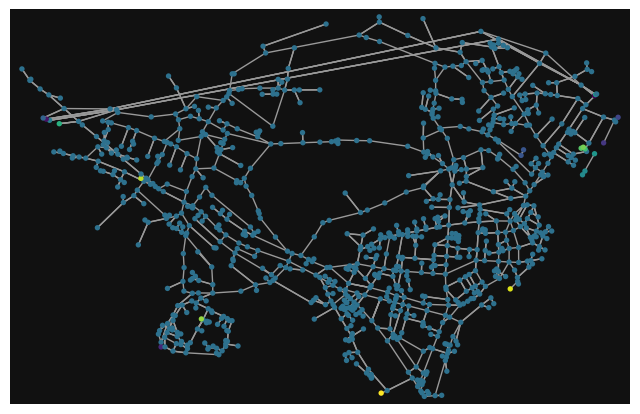

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# colors nodes by strongly connected component,
# use this visualization to check whether we have any major disconnects in the resulting lane graphs

L = snman.graph_tools.street_graph_to_lane_graph(H, MODE_PRIVATE_CARS, KEY_LANES_DESCRIPTION_AFTER)

# Calculate strongly connected components
components = list(nx.strongly_connected_components(L))

# Assign a different color to each component
colors = {}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# Draw the graph with nodes colored by component
oxc.plot_graph(L, node_color=[colors[node] for node in L.nodes()])

In [9]:
import pandas as pd

# calculate lane graph stats for different modes before and after the rebuild

res = pd.DataFrame([
    snman.graph_tools.calculate_lane_graph_stats(
        snman.graph_tools.keep_only_the_largest_connected_component(
            snman.graph_tools.street_graph_to_lane_graph(H, MODE_PRIVATE_CARS, KEY_LANES_DESCRIPTION)
            , weak=False
        )
    ),
    snman.graph_tools.calculate_lane_graph_stats(
        snman.graph_tools.keep_only_the_largest_connected_component(
            snman.graph_tools.street_graph_to_lane_graph(H, MODE_PRIVATE_CARS, KEY_LANES_DESCRIPTION_AFTER)
            , weak=False
        )
    ),
    snman.graph_tools.calculate_lane_graph_stats(
        snman.graph_tools.keep_only_the_largest_connected_component(
            snman.graph_tools.street_graph_to_lane_graph(H, MODE_CYCLING, KEY_LANES_DESCRIPTION)
            , weak=False
        )
    ),
    snman.graph_tools.calculate_lane_graph_stats(
        snman.graph_tools.keep_only_the_largest_connected_component(
            snman.graph_tools.street_graph_to_lane_graph(H, MODE_CYCLING, KEY_LANES_DESCRIPTION_AFTER)
            , weak=False
        )
    ),
])

res['mode'] = [MODE_PRIVATE_CARS, MODE_PRIVATE_CARS, MODE_CYCLING, MODE_CYCLING]
res['situation'] = ['before', 'after', 'before', 'after']

res = res.set_index(['mode', 'situation']).transpose()

res

mode                            private_cars                 cycling  \
situation                             before       after      before   
N_nodes                            933.00000   934.00000  1016.00000   
N_edges                           2313.00000  1830.00000  2857.00000   
N_strongly_connected_components      1.00000     1.00000     1.00000   
N_weakly_connected_components        1.00000     1.00000     1.00000   
lane_km                            258.46600   202.46700   328.05300   
lane_km/km2                         19.89100    15.58100    24.31300   
active_modes_only_lane_km            0.00000     0.00000    69.29000   
active_modes_only_lane_km/km2        0.00000     0.00000     5.13500   
avg_betweenness_centrality_norm      0.02094     0.03345     0.01781   
avg_shortest_path_length_km          2.48000     4.24200     1.98900   

mode                                         
situation                             after  
N_nodes                          1020.00000  
N_edges                          3147.00000  
N_strongly_connected_components     1.00000  
N_weakly_connected_components       1.00000  
lane_km                           360.36800  
lane_km/km2                        26.70800  
active_modes_only_lane_km         157.17200  
active_modes_only_lane_km/km2      11.64800  
avg_betweenness_centrality_norm     0.01774  
avg_shortest_path_length_km         1.47900

In [10]:
# =====================================================================================
# EXPORT
# =====================================================================================

if 1:
    print('Export network without lanes')
    snman.export_street_graph(G, export_path + 'edges.gpkg', export_path + 'nodes.gpkg')

if 0:
    print('Export OSM XML')
    snman.export_osm_xml(G, export_path + 'new_network.osm',{
        'highway', 'lanes', 'lanes:forward', 'lanes:backward', 'lanes:both_ways',
        'cycleway', 'cycleway:lane', 'cycleway:left', 'cycleway:left:lane', 'cycleway:right', 'cycleway:right:lane',
        'bus:lanes:backward', 'bus:lanes:forward', 'vehicle:lanes:backward', 'vehicle:lanes:forward',
        'maxspeed', 'oneway',
        '_connected_component'
    }, uv_tags=True, tag_all_nodes=True)

if 1:
    print('Export network with lanes')
    snman.export_street_graph_with_lanes(G, 'ln_desc', export_path + 'edges_lanes.shp', scaling=1)
    snman.export_street_graph_with_lanes(G, 'ln_desc_after', export_path + 'edges_lanes_after.shp', scaling=1)

Export network without lanes
Export network with lanes


In [11]:
# =====================================================================================
# GENERATE OD MATRIX FOR ACCESSIBILITY ANALYSES
# =====================================================================================

L = snman.graph_tools.street_graph_to_lane_graph(G, MODE_CYCLING, KEY_LANES_DESCRIPTION_AFTER)

# Snap POIs
nodes = oxc.graph_to_gdfs(L, edges=False)
nodes['node_geom'] = nodes.geometry
snapped_poi_gpd = gpd.sjoin_nearest(poi_gpd, nodes, how='inner', max_distance=1000)[['index_right','node_geom']]\
    .rename(columns={'node_geom':'geometry'}).set_geometry('geometry').set_index('index_right')


# Cost List

import itertools as it
import shapely as shp
import pandas as pd

ods = it.permutations(snapped_poi_gpd.index, 2)
a = gpd.GeoDataFrame(ods, columns=['origin', 'destination'])

a['origin_geom'] = snapped_poi_gpd.merge(a, left_index=True, right_on='origin')['geometry']
a['destination_geom'] = snapped_poi_gpd.merge(a, left_index=True, right_on='destination')['geometry']
a['od_line_geom'] = a.apply(
    lambda row: shp.LineString([row['origin_geom'], row['destination_geom']]),
    axis=1).set_crs(2056)
a['cost'] = a.apply(
    lambda row: nx.shortest_path_length(L, source=row['origin'], target=row['destination'], weight='cost'),
    axis=1)
a['od_path_geom'] = a.apply(
    lambda row: shp.LineString(
        nodes.loc[nx.shortest_path(L, source=row['origin'], target=row['destination'], weight='cost')]['geometry'])
    ,axis=1).set_crs(2056)

a_complete = a
a = a[['origin', 'destination', 'cost', 'od_path_geom']]
a = a.set_geometry('od_path_geom')
a.to_file(export_path + 'od.gpkg')

# List of Points
snapped_poi_gpd.to_file(export_path + 'cartogram_points.gpkg')

# OD Matrix
M = pd.DataFrame(index=snapped_poi_gpd.index, columns=snapped_poi_gpd.index)
M.index.name = None

for idx, row in a.iterrows():
    M.loc[row['origin'], row['destination']] = row['cost']
    M.loc[row['origin'], row['origin']] = 0
    M.loc[row['destination'], row['destination']] = 0

M.to_csv(export_path + 'od.csv')